In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data_wavlet = pd.read_csv('china_steel_wavelet_reconstructed_only.csv')
data_unadujsted = pd.read_csv('china_steel_stock_data_cleaned.csv')
data_wavlet.head()

,Date,Adj Close Reconstructed,Close Reconstructed,High Reconstructed,Low Reconstructed,Open Reconstructed,Volume Reconstructed
0,2023-12-01,25.605252,25.998476,26.003460,25.769923,25.913437,5.341702e+07
1,2023-12-04,25.604250,25.998292,26.003692,25.726025,25.912889,4.558319e+07
2,2023-12-05,25.647378,26.042370,26.048063,25.755233,25.918767,3.737264e+07
3,2023-12-06,25.737278,26.133323,26.141060,25.866490,25.974636,2.797251e+07
4,2023-12-07,25.640272,26.034362,26.182587,25.900512,26.034967,2.262090e+07


In [106]:
data_unadujsted.tail()

,Date,Adj Close,Close,High,Low,Open,Volume
241,2024-12-02,21.200001,21.200001,21.450001,21.200001,21.200001,14963847.0
242,2024-12-03,21.549999,21.549999,21.549999,21.250000,21.299999,15231884.0
243,2024-12-04,21.650000,21.650000,21.650000,21.400000,21.549999,13481864.0
244,2024-12-05,21.200001,21.200001,21.650000,21.200001,21.650000,12928639.0
245,2024-12-06,21.150000,21.150000,21.350000,21.100000,21.350000,11656615.0


In [139]:
data = data_unadujsted

In [140]:
data.rename(columns={'Close Reconstructed': 'Close'}, inplace=True)

In [141]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2023-12-01,26.000000
1,2023-12-04,26.049999
2,2023-12-05,26.100000
3,2023-12-06,26.250000
4,2023-12-07,26.049999
...,...,...
241,2024-12-02,21.200001
242,2024-12-03,21.549999
243,2024-12-04,21.650000
244,2024-12-05,21.200001


In [142]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

/tmp/ipykernel_334775/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


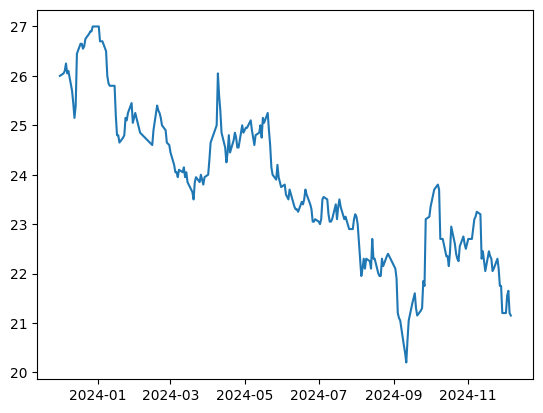

In [143]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [144]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2023-12-12,25.450001,25.700001,26.100000,26.049999,26.250000,26.100000,26.049999,26.000000
2023-12-13,25.150000,25.450001,25.700001,26.100000,26.049999,26.250000,26.100000,26.049999
2023-12-14,25.400000,25.150000,25.450001,25.700001,26.100000,26.049999,26.250000,26.100000
2023-12-15,26.450001,25.400000,25.150000,25.450001,25.700001,26.100000,26.049999,26.250000
2023-12-18,26.650000,26.450001,25.400000,25.150000,25.450001,25.700001,26.100000,26.049999
...,...,...,...,...,...,...,...,...
2024-12-02,21.200001,21.200001,21.750000,21.750000,22.100000,22.299999,22.100000,22.049999
2024-12-03,21.549999,21.200001,21.200001,21.750000,21.750000,22.100000,22.299999,22.100000
2024-12-04,21.650000,21.549999,21.200001,21.200001,21.750000,21.750000,22.100000,22.299999


In [145]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[25.45000076, 25.70000076, 26.10000038, ..., 26.10000038,
        26.04999924, 26.        ],
       [25.14999962, 25.45000076, 25.70000076, ..., 26.25      ,
        26.10000038, 26.04999924],
       [25.39999962, 25.14999962, 25.45000076, ..., 26.04999924,
        26.25      , 26.10000038],
       ...,
       [21.64999962, 21.54999924, 21.20000076, ..., 21.75      ,
        22.10000038, 22.29999924],
       [21.20000076, 21.64999962, 21.54999924, ..., 21.75      ,
        21.75      , 22.10000038],
       [21.14999962, 21.20000076, 21.64999962, ..., 21.20000076,
        21.75      , 21.75      ]])

In [146]:
shifted_df_as_np.shape

(239, 8)

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.54411782,  0.61764724,  0.7352942 , ...,  0.7352942 ,
         0.72058798,  0.70588232],
       [ 0.45588218,  0.54411782,  0.61764724, ...,  0.77941174,
         0.7352942 ,  0.72058798],
       [ 0.5294116 ,  0.45588218,  0.54411782, ...,  0.72058798,
         0.77941174,  0.7352942 ],
       ...,
       [-0.5735297 , -0.60294158, -0.70588232, ..., -0.54411782,
        -0.44117652, -0.38235332],
       [-0.70588232, -0.5735297 , -0.60294158, ..., -0.54411782,
        -0.54411782, -0.44117652],
       [-0.72058854, -0.70588232, -0.5735297 , ..., -0.70588232,
        -0.54411782, -0.54411782]])

In [148]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((239, 7), (239,))

In [149]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.70588232,  0.72058798,  0.7352942 , ...,  0.72058798,
         0.7352942 ,  0.61764724],
       [ 0.72058798,  0.7352942 ,  0.77941174, ...,  0.7352942 ,
         0.61764724,  0.54411782],
       [ 0.7352942 ,  0.77941174,  0.72058798, ...,  0.61764724,
         0.54411782,  0.45588218],
       ...,
       [-0.38235332, -0.44117652, -0.54411782, ..., -0.70588232,
        -0.70588232, -0.60294158],
       [-0.44117652, -0.54411782, -0.54411782, ..., -0.70588232,
        -0.60294158, -0.5735297 ],
       [-0.54411782, -0.54411782, -0.70588232, ..., -0.60294158,
        -0.5735297 , -0.70588232]])

In [150]:
split_index = int(len(X) * 0.95)

split_index

227

In [151]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227, 7), (12, 7), (227,), (12,))

In [152]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227, 7, 1), (12, 7, 1), (227, 1), (12, 1))

In [153]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([227, 7, 1]),
 torch.Size([12, 7, 1]),
 torch.Size([227, 1]),
 torch.Size([12, 1]))

In [154]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [155]:
train_dataset

In [156]:
from torch.utils.data import DataLoader

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [157]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([2, 7, 1]) torch.Size([2, 1])


In [158]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 32, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [159]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [160]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [161]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.110

Val Loss: 0.029
***************************************************

Epoch: 2
Batch 100, Loss: 0.027

Val Loss: 0.016
***************************************************

Epoch: 3
Batch 100, Loss: 0.029

Val Loss: 0.035
***************************************************

Epoch: 4
Batch 100, Loss: 0.024

Val Loss: 0.007
***************************************************

Epoch: 5
Batch 100, Loss: 0.022

Val Loss: 0.020
***************************************************

Epoch: 6
Batch 100, Loss: 0.022

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.018

Val Loss: 0.008
***************************************************

Epoch: 8
Batch 100, Loss: 0.018

Val Loss: 0.017
***************************************************

Epoch: 9
Batch 100, Loss: 0.016

Val Loss: 0.013
***************************************************

Epoch: 10
Batch 100, Loss: 0.011

Val Loss: 0.015
********************************

In [162]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([25.46564109, 25.27329948, 25.00425145, 25.38128805, 26.43723891,
       26.49662455, 26.39410586, 26.27954111, 26.39660197, 26.57884281,
       26.65672463, 26.68280035, 26.66934563, 26.78910668, 26.76464005,
       26.76619239, 26.40885434, 26.51844409, 26.52342375, 26.27486685,
       25.7078506 , 25.70917516, 25.70951461, 25.70725033, 25.68861127,
       24.94029816, 24.60519124, 24.75446565, 24.59862296, 24.70229517,
       24.73680745, 25.09362001, 24.98738908, 25.13061057, 25.34745893,
       24.84686331, 25.02927154, 25.17447196, 25.03056023, 24.68037531,
       24.45194497, 24.86679106, 25.39068014, 25.18216417, 25.0822111 ,
       24.99326488, 24.85702427, 24.78481802, 24.5240965 , 24.50872729,
       24.36234067, 24.09070422, 23.95275988, 23.9853141 , 23.88459839,
       24.03646645, 23.97886043, 24.0633308 , 23.84466852, 23.94981246,
       23.75761256, 23.59199903, 23.56144   , 23.42493526, 23.7899435 ,
       23.91452634, 23.75629758, 23.89184171, 23.80426985, 23.68

In [163]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/tmp/ipykernel_334775/2550294898.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([25.45000072, 25.14999966, 25.39999967, 26.45000075, 26.64999971,
       26.64999971, 26.54999922, 26.60000047, 26.74999999, 26.85000048,
       26.89999971, 26.89999971, 27.        , 27.        , 27.        ,
       26.70000076, 26.70000076, 26.70000076, 26.49999998, 25.99999997,
       25.85000045, 25.79999919, 25.79999919, 25.79999919, 25.20000071,
       24.79999926, 24.79999926, 24.64999964, 24.75000003, 24.79999926,
       25.14999966, 25.10000043, 25.25000005, 25.45000072, 25.04999927,
       25.14999966, 25.25000005, 25.14999966, 24.85000042, 24.60000041,
       24.89999965, 25.39999967, 25.29999928, 25.25000005, 25.14999966,
       25.00000004, 24.89999965, 24.64999964, 24.60000041, 24.45000079,
       24.20000079, 24.04999924, 24.04999924, 23.95000075, 24.1000004 ,
       24.04999924, 24.14999963, 23.95000075, 24.04999924, 23.85000039,
       23.70000076, 23.64999962, 23.5       , 23.85000039, 23.95000075,
       23.85000039, 24.00000001, 23.89999962, 23.79999923, 23.95

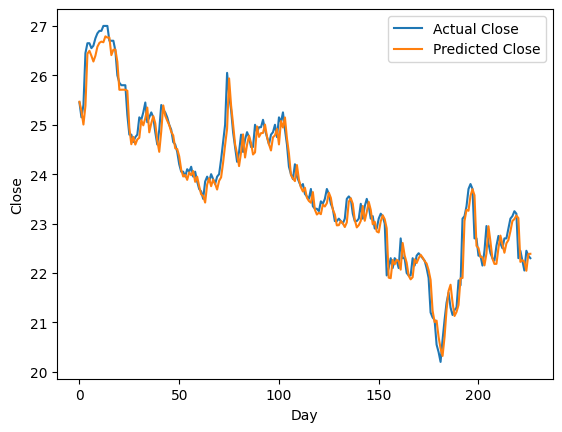

In [164]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [165]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([22.26698008, 22.00298801, 22.01177698, 22.25898865, 22.12637234,
       21.73047213, 21.65746458, 21.24479927, 21.14223113, 21.52639108,
       21.77032885, 21.33828863])

In [166]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_334775/1312012603.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([22.04999928, 22.10000034, 22.29999929, 22.10000034, 21.75000004,
       21.75000004, 21.20000079, 21.20000079, 21.54999926, 21.64999955,
       21.20000079, 21.14999954])

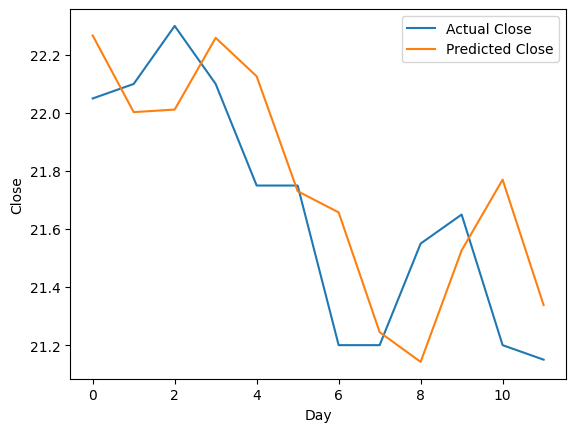

In [167]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Future 7 business days predictions:
        Date  Predicted_Close
0 2024-12-09        21.338289
1 2024-12-10        21.279418
2 2024-12-11        21.304830
3 2024-12-12        21.353612
4 2024-12-13        21.410724
5 2024-12-16        21.466938
6 2024-12-17        21.517735

Model Performance Metrics:
Training MSE: 0.0777
Test MSE: 0.0884


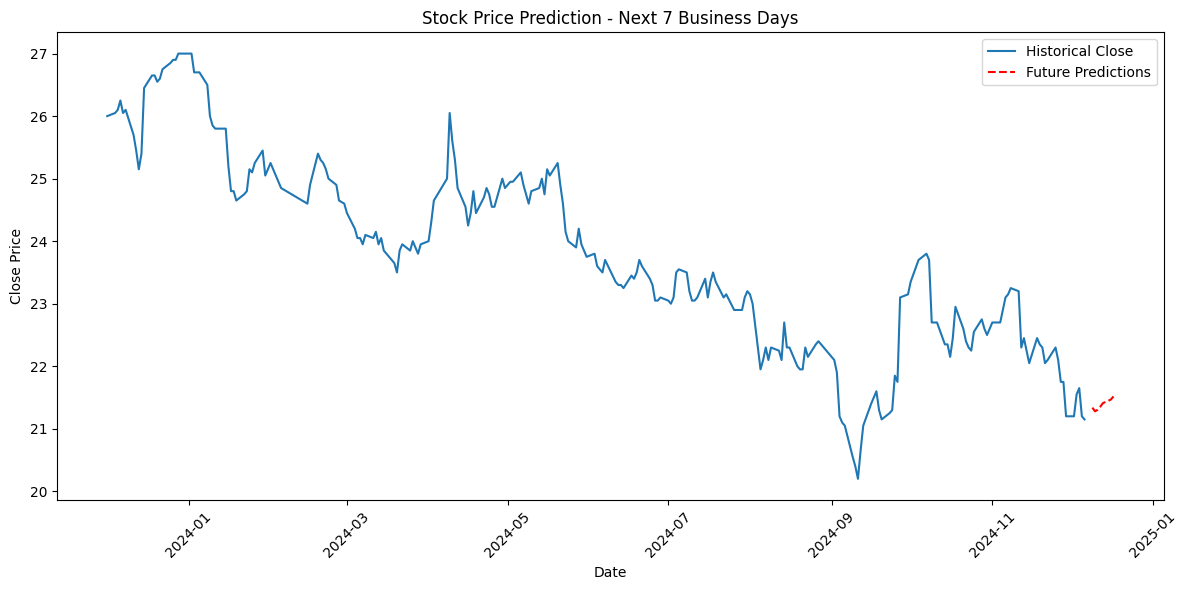

In [168]:
# Get the last 7 days of data to use as input for future predictions
last_7_days = X_test[-1:].to(device)  # Shape: [1, 7, 1]

# Generate future dates (skip weekends)
last_date = data['Date'].iloc[-1]  # This is Friday, 2024-12-06
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='B')
# This will give us the next 7 business days: Mon, Tue, Wed, Thu, Fri, Mon, Tue

# Predict next 7 business days
future_predictions = []
current_input = last_7_days.clone()

with torch.no_grad():
    for _ in range(7):
        # Get prediction for next day
        next_pred = model(current_input)
        future_predictions.append(next_pred.item())
        
        # Update input sequence by removing oldest prediction and adding new one
        current_input = current_input.roll(-1, dims=1)
        current_input[0, -1, 0] = next_pred

# Convert predictions back to original scale
dummy_array = np.zeros((len(future_predictions), lookback+1))
dummy_array[:, 0] = future_predictions
future_predictions_unscaled = scaler.inverse_transform(dummy_array)[:, 0]

# Create prediction results dataframe
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions_unscaled
})

print("Future 7 business days predictions:")
print(future_df)

# Calculate and print MSE for training and test sets
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(new_y_train, train_predictions)
test_mse = mean_squared_error(new_y_test, test_predictions)

print("\nModel Performance Metrics:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Plot historical + future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_df['Date'], future_df['Predicted_Close'], 'r--', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction - Next 7 Business Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()